In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '/home/janssens/scripts/pp3d/')
from functions import lowPass, mean_mask, getRad
from thermofunctions import *

In [3]:
# Inputs
itmin = 143
itmax = 144
di    = 1
izmin = 0
izmax = 80
klp = 4
qlmin = 1e-10
lp = '/scratch-shared/janssens/eurec4a_mean_100km'

ds = nc.Dataset(lp+'/fielddump.001.nc')
ds1= nc.Dataset(lp+'/profiles.001.nc')
ds0= nc.Dataset(lp+'/tmser.001.nc')

time  = np.ma.getdata(ds.variables['time'][:]) / 3600
zf    = np.ma.getdata(ds.variables['zt'][:]) # Cell centres (f in mhh)
zh    = np.ma.getdata(ds.variables['zm'][:]) # Cell edges (h in mhh)
xf    = np.ma.getdata(ds.variables['xt'][:]) # Cell centres (f in mhh)
yf    = np.ma.getdata(ds.variables['yt'][:]) # Cell centres (f in mhh)

time1d = np.ma.getdata(ds1.variables['time'][:])
rhobf = np.ma.getdata(ds1.variables['rhobf'][:])
rhobh = np.ma.getdata(ds1.variables['rhobh'][:])

plttime = np.arange(itmin, itmax, di)
zflim = zf[izmin:izmax]

# Mask for low-pass filtering
circ_mask = np.zeros((xf.size,xf.size))
rad = getRad(circ_mask)
circ_mask[rad<=klp] = 1

Ms = np.zeros((len(plttime),zflim.size))
wqt_mf = np.zeros((len(plttime),zflim.size))
wql_mf = np.zeros((len(plttime),zflim.size))
wthlv_mf = np.zeros((len(plttime),zflim.size))
wqt_av_time = np.zeros((len(plttime),zflim.size))
wql_av_time = np.zeros((len(plttime),zflim.size))
wthlv_av_time = np.zeros((len(plttime),zflim.size))

print('time: ', time[plttime])

time:  [36.]


/home/janssens/.conda/envs/ppaggenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app
/home/janssens/.conda/envs/ppaggenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
/home/janssen

/home/janssens/.conda/envs/ppaggenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
/home/janssens/.conda/envs/ppaggenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


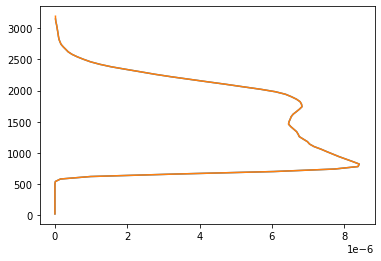

In [4]:
for i in range(len(plttime)):
    it1d = np.argmin(np.abs(time1d/3600 - time[plttime[i]]))
    
    # 1D fields
    rhobfi = rhobf[it1d,izmin:izmax]
    rhobhi = rhobh[it1d,izmin:izmax]
    
    # 3D fields
    qt  = np.ma.getdata(ds.variables['qt'][plttime[i],izmin:izmax,:,:])
    wh = np.ma.getdata(ds.variables['w'][plttime[i],izmin:izmax+1,:,:])
    thl =  np.ma.getdata(ds.variables['thl'][plttime[i],izmin:izmax,:,:])
    ql = np.ma.getdata(ds.variables['ql'][plttime[i],izmin:izmax,:,:])
    buoy =  np.ma.getdata(ds.variables['buoy'][plttime[i],izmin:izmax,:,:])
    # u = np.ma.getdata(ds.variables['u'][plttime[i],izmin:izmax,:,:])
    # v = np.ma.getdata(ds.variables['v'][plttime[i],izmin:izmax,:,:])
    
    # thlv
    thlv = thl + (rv/rd-1)*qt
    
    wf = (wh[1:,:,:] + wh[:-1,:,:])*0.5
    wh = wh[:-1,:,:]
    
    # Moist/dry definition
    twp = np.trapz(rhobfi[:,np.newaxis,np.newaxis]*qt[:,:,:],zflim,axis=0)
    twp = lowPass(twp, circ_mask)
    mask_moist = np.zeros(twp.shape)
    mask_moist[twp - np.mean(twp) > 0] = 1
    mask_dry = 1 - mask_moist
    
    # Compute T
    presh  = np.ma.getdata(ds1.variables['presh'][it1d,izmin:izmax])
    presf  = (presh[1:]+presh[:-1])*0.5
    exnf   = (presf/1e5)**(rd/cp)
    T = exnf[:,np.newaxis,np.newaxis]*thl[:-1,:,:] + rlv/cp*ql[:-1,:,:]
    
    # Compute qs
    qs = qsatur(T,presf[:,np.newaxis,np.newaxis])

    # Test qs -> Should give the same ql
    qltest = np.maximum(qt[:-1,:,:] - qs, 0.)
    plt.plot(np.mean(qltest,axis=(1,2)),zflim[:-1])
    plt.plot(np.mean(ql,axis=(1,2)),zflim)
    
    # Clausius-Claperyon equation
    qst = rlv*qs/rv/T**2
    
    # Slab-mean, fluctuation
    cm = ql.copy()
    cm[ql>=qlmin] = 1.
    cm[ql<qlmin] = 0.
    cf_av = np.mean(cm,axis=(1,2))
    
    ql_av = np.mean(ql,axis=(1,2))
    qlp = ql - ql_av[:,np.newaxis,np.newaxis]
    
    qs_av = np.mean(qs,axis=(1,2))
    qsp = qs - qs_av[:,np.newaxis,np.newaxis]
    
    thl_av = np.mean(thl,axis=(1,2))
    thlp = thl - thl_av[:,np.newaxis,np.newaxis]
    
    thlv_av = np.mean(thl,axis=(1,2))
    thlvp = thlv - thlv_av[:,np.newaxis,np.newaxis]
    
    qt_av = np.mean(qt,axis=(1,2))
    qtp = qt - qt_av[:,np.newaxis,np.newaxis]
    qtpf = lowPass(qtp,circ_mask)
    
    T_av = np.mean(T,axis=(1,2))
    
    # Actual flux
    wql_av_time[i,:] = np.mean(wf*qlp,axis=(1,2))
    
    # Cloud-conditioned average and fluctuation
    cmnan = cm.copy()
    cmnan[cmnan==0.] = np.nan

    # Slab-Average
    # a-verged over c-louds
    thlca = np.nanmean(thl*cmnan,axis=(1,2))
    thlvca = np.nanmean(thlv*cmnan,axis=(1,2))
    qlca = np.nanmean(ql*cmnan,axis=(1,2))
    qtca = np.nanmean(qt*cmnan,axis=(1,2))
    qsca = np.nanmean(qs*cmnan[:-1,:,:],axis=(1,2))
    wca = np.nanmean(wf*cmnan,axis=(1,2))
    
    # Moist areas
    
    # Averages
    wql_moist = mean_mask(wf*qlp,mask_moist) 
    ql_moist = mean_mask(ql,mask_moist)
    
    # Cloud average
    mask_moist_cl = cm.copy()
    for k in range(len(zflim)):
        mask_moist_cl[k,mask_moist==0.] = 0.
    mask_moist_cl[mask_moist_cl==0.] = np.nan
    
    cf_moist = np.nansum(mask_moist_cl,axis=(1,2))/np.sum(mask_moist)
    
    qlc_moist = np.nanmean(mask_moist_cl*ql,axis=(1,2))
    wc_moist = np.nanmean(mask_moist_cl*wf,axis=(1,2))
        

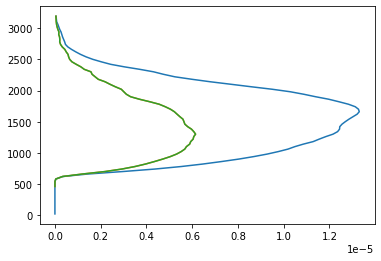

In [5]:
# Check how much flux you miss with the approximation wql_av \approx ac*wc*qlc
# Check that ac*qlc = ql_av
plt.plot(wql_av_time[0,:],zflim)
plt.plot(cf_av*wca*qlca,zflim)
plt.plot(wca*ql_av,zflim)

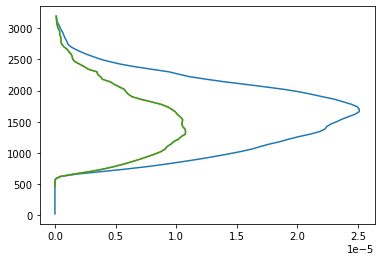

In [6]:
# Same for moist areas
plt.plot(wql_moist,zflim)
plt.plot(cf_moist*wc_moist*qlc_moist,zflim)
plt.plot(wc_moist*ql_moist,zflim)

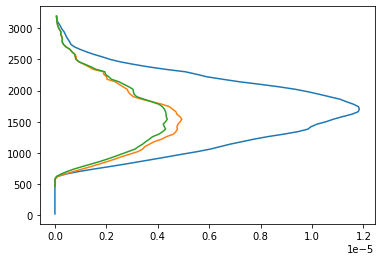

In [7]:
# To which extent can you model the flux anomaly by the ql anomaly?
# - Assumption 1: Same as above
# - Assumption 2: wc_moist*ql_moist - wca*qla \approx wca*(ql_moist - ql_av)
plt.plot(wql_moist-wql_av_time[0,:],zflim)
plt.plot(wc_moist*ql_moist - wca*ql_av,zflim)
plt.plot(wca*(ql_moist - ql_av),zflim)

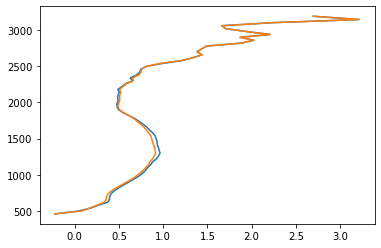

In [8]:
plt.plot(wc_moist,zflim)
plt.plot(wca,zflim)